<a href="https://colab.research.google.com/github/K1EH/Software-Maestro/blob/main/Pinecone_Data_Upsert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Library**

In [ ]:
# Vector Embedding
!pip install -q kobert-transformers

# Pinecone
!pip install -q pinecone
!pip install -q pinecone-plugin-inference
!pip install -q pinecone-plugin-interface
!pip install -q pinecone-client
!pip install -q protoc-gen-openapiv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.8/419.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.2 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.2 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<

## **Google Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Custom Functions**

In [ ]:
def df_left_align(df, num_rows=5):
    """
    스타일을 적용하여 데이터프레임을 좌측 정렬합니다.

    Parameters:
    df (pd.DataFrame): 스타일을 적용할 데이터프레임
    num_rows (int): 출력할 행의 수, 기본값은 5

    Returns:
    pd.io.formats.style.Styler: 좌측 정렬 스타일이 적용된 데이터프레임
    """
    styled_df = df.head(num_rows).style.set_properties(**{'text-align': 'left'})
    styled_df = styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    return styled_df

# **Data Preprocessing for Upsert VectorDB**

## **Data Preprocessing**

**Load Data**

In [ ]:
dataset_path = "/content/drive/MyDrive/datasets/V2_QuestionsListforVectorDB.csv"

In [ ]:
import pandas as pd

# 엑셀 파일을 읽어옵니다.
df = pd.read_csv(dataset_path, encoding = "utf-8")

df

,태그,질문,기술 분야,기술 키워드,세부 기술 키워드
0,"be, architecture, real-time_data_processing","네이버 쇼핑 탭에서 보여지는 상품의 노출 순위를 조회할 때, 실시간성을 반영해야한다...",BE,Architecture,real-time data processing
1,crawling,크롤러가 블락되는 경우 어떻게 대응하는 것이 좋을까요?,BE,Crawling,NaN
2,NaN,"인증 방식으로 JWT를 사용해 보신 적이 있다면, JWT에 대해 간단히 설명해 주실...","BE, FE",JWT,NaN
3,"be, jpa, n+1","JPA를 사용하실 때, N+1 문제를 겪어보셨다면 경험한 사례와 해결한 방법에 대해...",BE,JPA,n+1
4,experience,날짜 및 상품 별 판매 데이터 집계 과정에서 발생한 성능 문제는 없었나요?,BE,DB,NaN
...,...,...,...,...,...
746,NaN,"Model, View, Controller의 차이는 무엇인가요?","BE, FE",Design Pattern,NaN
747,NaN,Forward와 Redirect의 차이는 무엇인가요?,"BE, FE",Design Pattern,NaN
748,NaN,Vue.js의 라이프사이클 함수에 대해 설명해 주실 수 있나요?,FE,Vue.js,NaN
749,NaN,동기와 비동기의 차이를 예시를 들어 설명해 주실 수 있나요?,"BE, FE",Basic,NaN


**Data Preprocessing**

In [ ]:
df_subset = df[['질문', '기술 분야', '기술 키워드']].dropna()
df_subset

,질문,기술 분야,기술 키워드
0,"네이버 쇼핑 탭에서 보여지는 상품의 노출 순위를 조회할 때, 실시간성을 반영해야한다...",BE,Architecture
1,크롤러가 블락되는 경우 어떻게 대응하는 것이 좋을까요?,BE,Crawling
2,"인증 방식으로 JWT를 사용해 보신 적이 있다면, JWT에 대해 간단히 설명해 주실...","BE, FE",JWT
3,"JPA를 사용하실 때, N+1 문제를 겪어보셨다면 경험한 사례와 해결한 방법에 대해...",BE,JPA
4,날짜 및 상품 별 판매 데이터 집계 과정에서 발생한 성능 문제는 없었나요?,BE,DB
...,...,...,...
746,"Model, View, Controller의 차이는 무엇인가요?","BE, FE",Design Pattern
747,Forward와 Redirect의 차이는 무엇인가요?,"BE, FE",Design Pattern
748,Vue.js의 라이프사이클 함수에 대해 설명해 주실 수 있나요?,FE,Vue.js
749,동기와 비동기의 차이를 예시를 들어 설명해 주실 수 있나요?,"BE, FE",Basic


In [ ]:
# 특정 컬럼을 리스트로 변환합니다.
questions = df_subset['질문'].tolist()
tech_fields = df_subset['기술 분야'].apply(lambda x: x.split(', ')).tolist()
tech_keywords = df_subset['기술 키워드'].apply(lambda x: x.split(', ')).tolist()

print(tech_fields)

[['BE'], ['BE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE'], ['BE'], ['FE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], ['BE', 'FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['BE', 'FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['BE', 'FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['BE', 'FE'], ['BE', 'FE'], ['FE'], ['BE', 'FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['FE'], ['BE', 'FE'], ['BE'], ['BE', 'FE'], ['BE', 'FE'], ['BE', 'FE'], ['BE'], [

**Create uuid**

In [ ]:
import uuid
uuid_list = []
for _ in range(len(questions)):
  uuid_list.append(str(uuid.uuid4()))
print(f"{uuid_list[0:5]}\n{len(uuid_list)}")

['e6916fa4-6324-4f10-96a6-3465e79f7341', 'b561cc90-8e0c-4d0a-9fa7-bea359885890', '8973541e-2b86-48a1-9ee5-bf7d7bb74692', '43445724-37b4-4593-ae39-9b61b9e3b891', 'aeff1d6d-4ad7-4266-82a8-343d09cd9624']
748


**Vector Embedding**

In [ ]:
from kobert_transformers import get_kobert_model, get_tokenizer
import torch

# KoBERT 모델 및 토크나이저 로드
model = get_kobert_model()
tokenizer = get_tokenizer()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

tokenizer_78b3253a26.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# 문장을 KoBERT 모델의 입력에 맞게 토큰화
inputs = tokenizer(questions, return_tensors='pt', padding=True, truncation=True)

# KoBERT로 문장 임베딩 생성 (CLS 토큰의 출력을 사용)
with torch.no_grad():
    outputs = model(**inputs)
    sentence_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 사용

# 벡터 형태로 변환
embeddings = sentence_embeddings.numpy()

print(embeddings)

[[ 0.0425319   0.2514316  -0.09111914 ...  0.07490167  0.10408019
  -0.10047758]
 [-0.00954049  0.0753772  -0.15084937 ... -0.01527991 -0.07755385
  -0.00954415]
 [-0.1587557  -0.26383924 -0.01294001 ... -0.0924188   0.18203361
   0.02941136]
 ...
 [-0.19908951 -0.08817222 -0.27058792 ... -0.02896661  0.11983963
   0.36723873]
 [-0.12343694 -0.15797482  0.00607519 ...  0.05413169  0.23927818
  -0.07162219]
 [-0.05071395 -0.254854    0.00405341 ... -0.01235773  0.2403967
   0.0651174 ]]


**Save Preprocessed Datasets as JSON**

파일 저장 후 꼭 다운로드, Colab 세션 종료 시 데이터 소실됨

In [ ]:
import json

# 딕셔너리 형태로 데이터 결합
data = {
    "uuid_list": uuid_list,
    "questions": questions,
    "embeddings":embeddings.tolist(),
    "tech_fields": tech_fields,
    "tech_keywords": tech_keywords
}

# JSON 파일로 저장
output_path = '/content/drive/MyDrive/datasets/V2_PreprocessedDataset.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [ ]:
with open('/content/drive/MyDrive/datasets/V2_PreprocessedDataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
# 특정 컬럼 데이터 조회
json_uuid_list = data['uuid_list']
json_questions = data['questions']
json_embeddings = data['embeddings']
json_tech_fields = data['tech_fields']
json_tech_keywords = data['tech_keywords']

df_loaded = pd.DataFrame(data)

# 변환된 DataFrame 출력
df_loaded

,uuid_list,questions,embeddings,tech_fields,tech_keywords
0,e6916fa4-6324-4f10-96a6-3465e79f7341,"네이버 쇼핑 탭에서 보여지는 상품의 노출 순위를 조회할 때, 실시간성을 반영해야한다...","[0.042531903833150864, 0.2514316141605377, -0....",[BE],[Architecture]
1,b561cc90-8e0c-4d0a-9fa7-bea359885890,크롤러가 블락되는 경우 어떻게 대응하는 것이 좋을까요?,"[-0.009540487080812454, 0.0753772035241127, -0...",[BE],[Crawling]
2,8973541e-2b86-48a1-9ee5-bf7d7bb74692,"인증 방식으로 JWT를 사용해 보신 적이 있다면, JWT에 대해 간단히 설명해 주실...","[-0.15875570476055145, -0.2638392448425293, -0...","[BE, FE]",[JWT]
3,43445724-37b4-4593-ae39-9b61b9e3b891,"JPA를 사용하실 때, N+1 문제를 겪어보셨다면 경험한 사례와 해결한 방법에 대해...","[-0.11110404878854752, -0.011801945976912975, ...",[BE],[JPA]
4,aeff1d6d-4ad7-4266-82a8-343d09cd9624,날짜 및 상품 별 판매 데이터 집계 과정에서 발생한 성능 문제는 없었나요?,"[0.15968304872512817, -0.32694166898727417, 0....",[BE],[DB]
...,...,...,...,...,...
743,5f2f3904-17d9-427b-be07-17c95d27ca90,"Model, View, Controller의 차이는 무엇인가요?","[-0.07267197221517563, 0.12576866149902344, 0....","[BE, FE]",[Design Pattern]
744,296de267-cebe-4bc3-b1a2-2d0871e259dd,Forward와 Redirect의 차이는 무엇인가요?,"[-0.1148453801870346, 0.0807654932141304, 0.15...","[BE, FE]",[Design Pattern]
745,c7b3d6bd-178d-4968-8627-f4a111400e77,Vue.js의 라이프사이클 함수에 대해 설명해 주실 수 있나요?,"[-0.19908951222896576, -0.08817221969366074, -...",[FE],[Vue.js]
746,e83737f5-6259-4854-b023-e315a231457e,동기와 비동기의 차이를 예시를 들어 설명해 주실 수 있나요?,"[-0.12343694269657135, -0.15797482430934906, 0...","[BE, FE]",[Basic]


**Check Tech Keywords**

In [ ]:
json_tech_keywords

[['Architecture'],
 ['Crawling'],
 ['JWT'],
 ['JPA'],
 ['DB'],
 ['DB'],
 ['DB'],
 ['softskill'],
 ['softskill'],
 ['Blockchain', 'memcashed'],
 ['message queue'],
 ['rate limit'],
 ['zero-downtime deployment'],
 ['Architecture'],
 ['DB'],
 ['DB'],
 ['Django'],
 ['softskill'],
 ['softskill'],
 ['rate limit'],
 ['overload'],
 ['DB'],
 ['DB'],
 ['DB'],
 ['UI/UX'],
 ['softskill'],
 ['softskill'],
 ['softskill'],
 ['Architecture'],
 ['Architecture'],
 ['Architecture'],
 ['Architecture'],
 ['Architecture'],
 ['Architecture'],
 ['opensource'],
 ['Architecture'],
 ['Spring'],
 ['Architecture'],
 ['Monolithic Architecture'],
 ['Architecture'],
 ['Architecture'],
 ['Vue.js'],
 ['Architecture'],
 ['Spring'],
 ['firewall'],
 ['CI/CD'],
 ['http'],
 ['Spring'],
 ['JWT'],
 ['domain_music'],
 ['kubernetes'],
 ['Big Data'],
 ['Redis'],
 ['reuse'],
 ['UI/UX'],
 ['Spring'],
 ['Architecture'],
 ['Basic'],
 ['DB'],
 ['Architecture'],
 ['Architecture'],
 ['DB'],
 ['JWT'],
 ['JavaScript'],
 ['JavaScript'],
 

In [ ]:
from collections import Counter

# 개수 카운팅 및 중복 없이 리스트 반환
# 플랫 리스트 생성 및 카운팅
flat_list = [item for sublist in json_tech_keywords for item in sublist]
keyword_counts = Counter(flat_list)
unique_keywords = list(keyword_counts.keys())

print("Keyword Counts:", keyword_counts)
print("Unique Keywords:", unique_keywords)
tech_keywords_df = pd.DataFrame(list(keyword_counts.items()), columns=['Keyword', 'Count'])
tech_keywords_df

Keyword Counts: Counter({'Basic': 90, 'JavaScript': 85, 'java': 76, 'DB': 48, 'Architecture': 41, 'Spring': 31, 'OOP': 25, 'OS': 24, 'CSS': 18, 'softskill': 16, 'testing': 16, 'security': 15, 'http': 13, 'React': 13, 'state management': 13, 'cache': 11, 'Data Structure': 11, 'Typescript': 10, 'message queue': 8, 'UI/UX': 8, 'ECMAScript': 8, 'Network': 8, 'Design Pattern': 8, 'JWT': 7, 'Vue.js': 7, 'git': 7, 'bundler': 7, 'monitoring': 7, 'AWS': 6, 'CI/CD': 5, 'rendering': 5, 'refactoring': 4, 'Container': 4, 'zero-downtime deployment': 3, 'SEO': 3, 'Debounce': 3, 'throttle': 3, 'Kotlin': 3, 'TCP': 3, 'Algorithm': 3, 'rate limit': 2, 'kubernetes': 2, 'domain design': 2, 'tree shaking': 2, 'proxy server': 2, 'traffic': 2, 'error': 2, 'websocket': 2, 'API': 2, 'GC': 2, 'SPA': 2, 'ai': 2, 'mobile': 2, 'Session': 2, 'DDD': 2, 'Crawling': 1, 'JPA': 1, 'Blockchain': 1, 'memcashed': 1, 'Django': 1, 'overload': 1, 'opensource': 1, 'Monolithic Architecture': 1, 'firewall': 1, 'domain_music': 1, 

,Keyword,Count
0,Architecture,41
1,Crawling,1
2,JWT,7
3,JPA,1
4,DB,48
...,...,...
96,AJAX,1
97,Redux,1
98,redux sage,1
99,Angular,1


# **API KEYS / Environment Variable Setting**

In [ ]:
PINECONE_API_KEY = "4674af83-b175-427b-94a8-c91475f5cf93"

## **Pinecone Setting**

In [ ]:
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key = PINECONE_API_KEY)

**Version에 따른 index_name 관리**

In [ ]:
index_name = "v2-tech-questions"

In [ ]:
# index_name이 존재하지 않는 경우, 새 index 생성
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=768, # KoBERT의 벡터 차원은 768
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )
else:
  index = pc.Index(index_name)

[Pinecone-생성된 index 확인](https://app.pinecone.io/organizations/-O5gSVhLYwEb_91KPO77/projects/86f3ee9d-62ba-4885-8503-348118c90769/indexes)

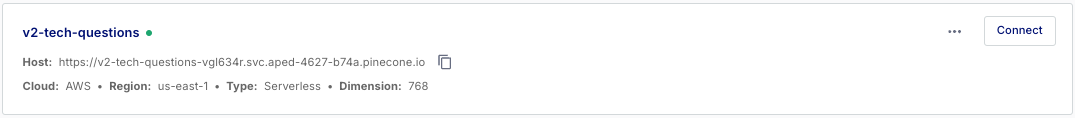

# **Upsert Data to Vector DB**

**Vectors to Upsert Vector DB**

In [ ]:
vectors_for_be_namespace = []
vectors_for_fe_namespace = []
for uuid, question, embedding, tech_field, tech_keyword in zip(json_uuid_list, json_questions, json_embeddings, json_tech_fields, json_tech_keywords):
  ### ['ID', 'Value', 'Metadata'] ###
  if "BE" in tech_field:
    vectors_for_be_namespace.append((uuid, embedding, {"text" : question, "tech_keyword" : tech_keyword}))
  if "FE" in tech_field:
    vectors_for_fe_namespace.append((uuid, embedding, {"text" : question, "tech_keyword" : tech_keyword}))

In [ ]:
print(len(vectors_for_be_namespace))
print(len(vectors_for_fe_namespace))

515
425


In [ ]:
index.upsert(
    vectors=vectors_for_be_namespace,
    namespace="BE")

upserted_count: 515

In [ ]:
index.upsert(
    vectors=vectors_for_fe_namespace,
    namespace="FE")

upserted_count: 425

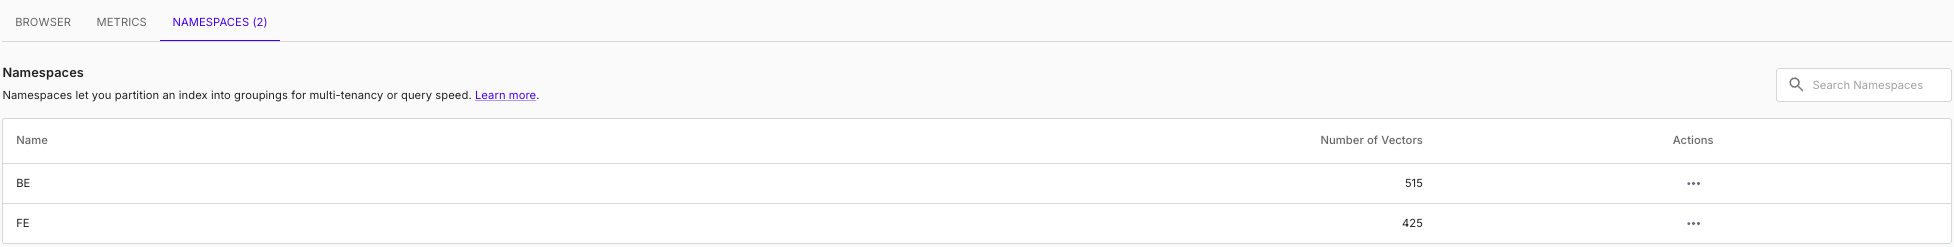